The goal of this notebook is to build a simple Convolutional Neural Network (CNN) and to train it on the MNIST database (images of digits 0-9). We have seen that a linear classifier could reach 90% accuracy on this data-set, thus we have to outperform this result with a CNN.

This notebook is divided in two parts:

- define convolution operation with Pytorch
- build a CNN neural network
- *exercise*: train the network and investigate the results

<div>
<img src="https://drive.google.com/uc?id=1agIhJ7Rr-hfw8rCdxqaKDQPl54Rf5sZc" width="600"/>
</div>


# Convolution
## Convolution with *numpy*
We have already seen previously convolution operation using the library *numpy* for 1D convolution using the function *numpy.convolve*.


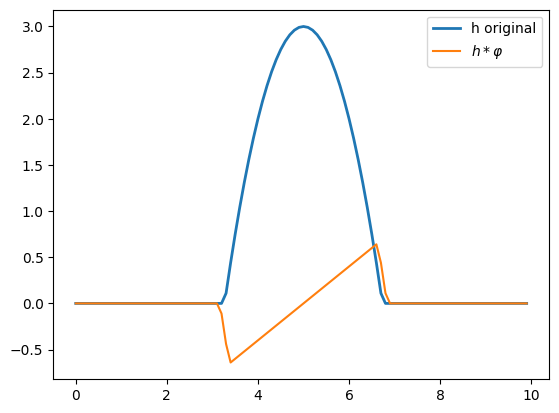

In [2]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0,10,.1)
h = np.maximum(3 - (x-5)**2,0)
phi = np.array([-1,0,1])
h_conv_phi = np.convolve(h,phi,'same')
plt.figure(1)
plt.plot(x,h,label="h original",linewidth=2)
plt.plot(x,h_conv_phi,label=r"$h*\varphi$")
plt.legend()
plt.show()

In 2D, we could use the library *signal*:



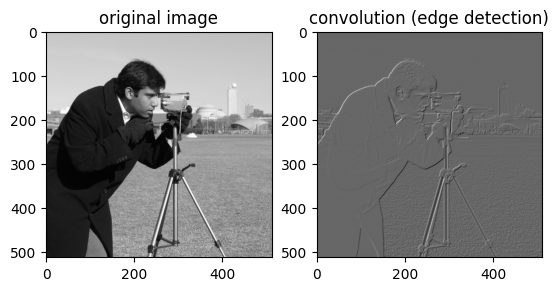

In [5]:
from skimage import data        # to get the cameraman
from scipy import signal        # convolution 2D
img = data.camera()
phi_2D = np.array([[0,-1,0],[-1,0,1],[0,1,0]])
img_conv_phi = signal.convolve2d(img, phi_2D, boundary='symm', mode='same')
plt.figure(2)
plt.subplot(121)
plt.imshow(img,cmap="gray")
plt.title("original image")
plt.subplot(122)
plt.imshow(img_conv_phi,cmap="gray")
plt.title("convolution (edge detection)")
plt.show()

## Convolution with *torch*

The library *torch* has its own implementation of the convolution operator since it needs to perform this operation over and over again. Let's define the previous 2D convolution using the *torch* library.


In [6]:
import torch
import torch.nn as nn
myConv = nn.Conv2d(1, 1, 3)

The object *myConv* is not a filter but rather the (linear) operation: $h→h*\varphi$ where $h$ is the input image and $\varphi$ the filter. <br>
But what is the filter $\varphi$ in used here? Let's first describe the three default parameters used $(1,1,3)$. The first two values ($1$ and $1$) correspond to the number of *in* channel and *out* channel. The third value $3$ corresponds to the size of the kernel (thus the kernel is $3$x$3$). There are other parameters with some default values, see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) for more details.

Now we would like to know what **is** the kernel in *myConv*. We need to *unwrap* what is in *myConv*. We can list all the attributes and methods associated with it using the command *dir*.


In [7]:
dir(myConv)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_conv_forward',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_me

The relevant information is given by the attribute *weights*.



In [8]:
print(myConv.weight)
print(myConv.weight.shape)

Parameter containing:
tensor([[[[ 0.1650,  0.0761,  0.3111],
          [-0.0690, -0.1168,  0.1394],
          [ 0.0119, -0.0310, -0.3269]]]], requires_grad=True)
torch.Size([1, 1, 3, 3])


Thus, the kernel is actually of size $[1,1,3,3]$ (it is $4$-tensor): $N\times C\times H\times W$ where $N$ is the size of mini-batch, $C$ the number of channels ($1$ for gray image, $3$ for RGB), $H$ and $W$ are the height and the width of the image (in pixels). To change the values of the kernel, we can proceed as follow:



In [9]:
phi_2D = np.array([[0,-1,0],[-1,0,1],[0,1,0]])
for i in range(3):
    for j in range(3):
        myConv.weight.data[0][0][i,j] = float(phi_2D[i,j])
myConv.weight

Parameter containing:
tensor([[[[ 0., -1.,  0.],
          [-1.,  0.,  1.],
          [ 0.,  1.,  0.]]]], requires_grad=True)

We can apply the convolution to our image. But we need first to transform the image into a tensor then apply the convolution.



In [10]:
from skimage import data
img_array = data.camera()
print(type(img_array))
img_tensor = torch.from_numpy(img_array).float()  # the extra .float() is to convert into 'float' insead of 'bytes'
print(type(img_tensor))

<class 'numpy.ndarray'>
<class 'torch.Tensor'>


Notice that here *img_array* is a **numpy** array. In general, we will deal with image, i.e. a **PIL** object. In that case, we need to use the library *torchvision* to transform an image into a tensor. For instance, let's transform a numpy array into an image and then transform it into a tensor:



In [11]:
from PIL import Image
from torchvision import transforms
img_PIL = Image.fromarray(np.uint8(img_array))    # the image is now a PIL object
print(type(img_PIL))
myTranform = transforms.ToTensor()                # transform PIL object into tensor
img_tensor2 = myTranform(img_PIL)
print(img_tensor2.shape)

<class 'PIL.Image.Image'>
torch.Size([1, 512, 512])


We are now almost ready to apply the transformation. The following command gives an error:



In [12]:
img_conv = myConv(img_tensor)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [512, 512]

The problem is the shape of the tensor *img_tensor*: it is a 2-tensor of size $H\times W$ (i.e. a matrix). But the function *myConv* is expecting as input a 4-tensor (i.e. $N\times C \times H\times W$). Thus, we have to add two dimensions of size $0$ using the method *view* (similar to *reshape*).



In [13]:
H,W = img_tensor.shape
print(img_tensor.shape)
print(img_tensor.view(1,1,H,W).shape)

torch.Size([512, 512])
torch.Size([1, 1, 512, 512])


Now we can finally apply the convolution and plot the result (transforming it back into a *numpy* object):



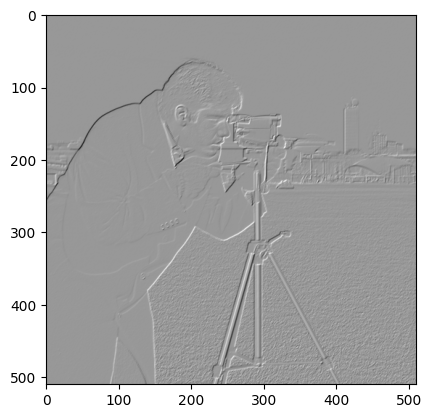

In [14]:
img_conv = myConv(img_tensor.view(1,1,H,W))
plt.figure(3)
plt.imshow(img_conv.detach().numpy()[0,0,],cmap="gray")
plt.show()

## Other operations: *pooling*

Another common operation in neural network for image classification is *subsampling* also called *pooling*. The idea is to only keep the local maximum (*max pooling*) on each small block. See also [max pool](https://pytorch.org/docs/stable/nn.html#maxpool2d).


<div>
<img src="https://drive.google.com/uc?id=1VFMAhaDYy1Nd5cDZ4hbIYiZUUC5WpMWr" width="400"/>
</div>


size before pooling torch.Size([1, 1, 512, 512])
size after pooling torch.Size([1, 1, 256, 256])
size after two pooling torch.Size([1, 1, 128, 128])
size after three pooling torch.Size([1, 1, 64, 64])


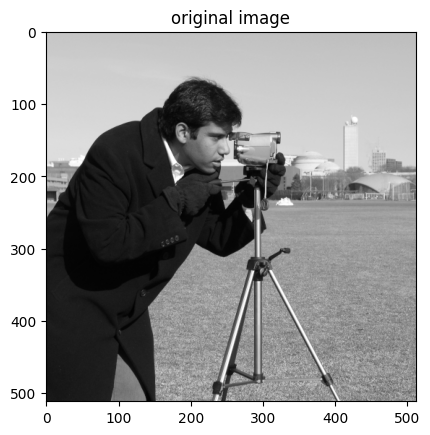

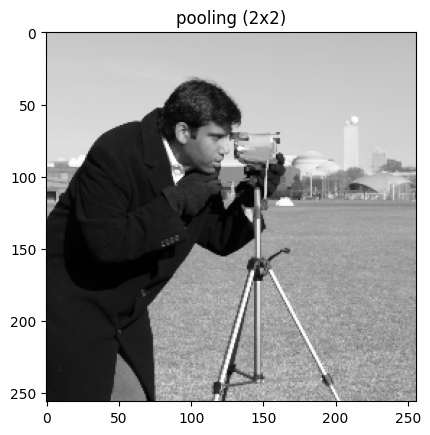

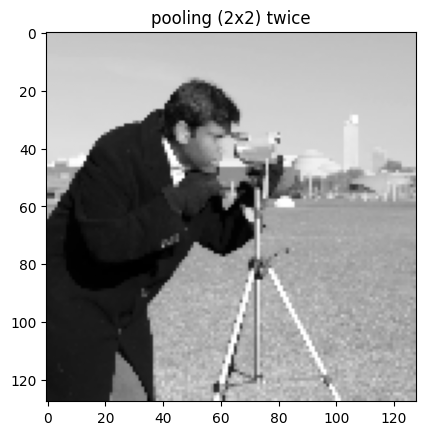

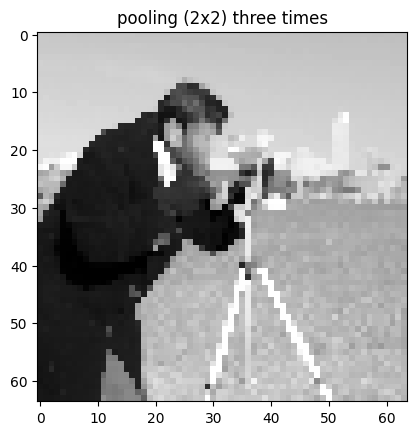

In [15]:
# define the function pooling (2x2)
myPooling = nn.MaxPool2d(2)
# apply it three time to an image
img_pool_zero = img_tensor.view(1,1,H,W)
img_pool_one = myPooling(img_pool_zero)
img_pool_two = myPooling(img_pool_one)
img_pool_three = myPooling(img_pool_two)
print('size before pooling '+str(img_pool_zero.shape))
print('size after pooling '+str(img_pool_one.shape))
print('size after two pooling '+str(img_pool_two.shape))
print('size after three pooling '+str(img_pool_three.shape))
# plot
plt.figure(1)
plt.imshow(img_pool_zero.detach().numpy()[0,0,],cmap="gray")
plt.title("original image")
plt.figure(2)
plt.imshow(img_pool_one.detach().numpy()[0,0,],cmap="gray")
plt.title("pooling (2x2)")
plt.figure(3)
plt.imshow(img_pool_two.detach().numpy()[0,0,],cmap="gray")
plt.title("pooling (2x2) twice")
plt.figure(4)
plt.imshow(img_pool_three.detach().numpy()[0,0,],cmap="gray")
plt.title("pooling (2x2) three times")
plt.show()


# Building convolutional neural networks
## Playing with transformations
We now have all the tools to build a convolution neural network. We will use a three layers neural networks (see illustration):

<center>convolution (+ReLu) --> pooling --> convolution (+Relu) --> linear </center>

<br>


<div>
<img src="https://drive.google.com/uc?id=1FBtozW9PRtCiS63ijgEWc0RFApcB0Oc0" width="800"/>
</div>


In [16]:
from torchvision import datasets
import torchvision.transforms as transforms
# load data-set (notice the additional option 'transform' to return a tensor instead of a PIL image)
MNIST_training_set = datasets.MNIST('~/Teaching/Deep_net/data_sets', train=True, download=True, transform=transforms.ToTensor())
MNIST_test_set = datasets.MNIST('~/Teaching/Deep_net/data_sets', train=False, download=True, transform=transforms.ToTensor())
X,y = MNIST_training_set.__getitem__(12)
X.shape

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting /root/Teaching/Deep_net/data_sets/MNIST/raw/train-images-idx3-ubyte.gz to /root/Teaching/Deep_net/data_sets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting /root/Teaching/Deep_net/data_sets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/Teaching/Deep_net/data_sets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.80MB/s]


Extracting /root/Teaching/Deep_net/data_sets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/Teaching/Deep_net/data_sets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.25MB/s]

Extracting /root/Teaching/Deep_net/data_sets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Teaching/Deep_net/data_sets/MNIST/raw



torch.Size([1, 28, 28])

Let's now play with transformations (convolution, ReLu, maxpool) applied on X.

In [17]:
# first convolution
myConv1 = nn.Conv2d(1, 4, 3) # from 1 to 4 channels, kernel of size 3x3
Z1 = myConv1(X.view(1,1,28,28))  # put X in the right format
Z1.shape

torch.Size([1, 4, 26, 26])

In [18]:
# pooling layer
myPool =  nn.MaxPool2d(2)
Z2 = myPool(Z1)
Z2.shape

torch.Size([1, 4, 13, 13])

In [21]:
# second convolution
myConv2 = nn.Conv2d(4, 8, 5) # from 4 to 8 channels, kernel of size 5x5
Z3 = myConv2(Z2.view(1,4,13,13))  # put Z3 in the right format
Z3.shape

torch.Size([1, 8, 9, 9])

In [22]:
# final layer
myLinear = nn.Linear(8*9*9, 10) # input -> 8*9*9 ; output -> 10
S = myLinear(Z3.view(1,-1))   # "-1" means "put the correct number"
S

tensor([[ 0.1823,  0.0858, -0.1896, -0.0746,  0.0106,  0.0118, -0.0120,  0.0833,
         -0.0608, -0.0722]], grad_fn=<AddmmBackward0>)

## Building a class CNN
We now have to combine our previous play-around into a single function that will define our CNN. As usual in Python, the neural networkwill be an object. Thus, we need to define a class and our network will be an instance of this class.

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F   # to define the ReLu function

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()   # initialize the parent class 'nn.Module'
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.pool  = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(4, 8, 5)
        self.fc = nn.Linear(8*9*9, 10)

    def forward(self, x):
        z1 = F.relu(self.conv1(x))
        z2 = self.pool(z1)
        z3 = F.relu(self.conv2(z2))
        s = self.fc(z3.view(-1, 8*9*9))
        return s

Let's define one instance of this class and let's investigate how many parameters are needed.

In [24]:
myModel = SimpleCNN()
# count the number of parameters
sum(p.numel() for p in myModel.parameters() if p.requires_grad)

7338

It is roughly the same number as a linear model. The last layer of our network is the more demanding in term of parameters.

## Training
Let's train the model. First, we have to initialize.

In [25]:
from torchvision import datasets
from torch.utils.data import DataLoader
import pandas as pd
import time
#---   A) Hyper-parameters ---#
cfg = dict()
cfg['numEpoch'] = 10
cfg['learning_rate'] = .0001
cfg['batchSize'] = 20
#---   B) Initialization   ---#
# B.1) load the data
myLoader_train = DataLoader(MNIST_training_set, shuffle=True, batch_size=cfg['batchSize'])
myLoader_test = DataLoader(MNIST_test_set, shuffle=False, batch_size=cfg['batchSize'])
N_train = len(MNIST_training_set) # number of images in the training set
N_test = len(MNIST_test_set)
nbr_miniBatch_train = len(myLoader_train) # number of mini-batches
nbr_miniBatch_test = len(myLoader_test)
# B.2) optimizer
optimizer = torch.optim.Adam(myModel.parameters(), lr=cfg['learning_rate'])
# B.3) the loss
myLoss = nn.CrossEntropyLoss()
# B.4) saving
df = pd.DataFrame(index=range(cfg['numEpoch']),columns=('epoch', 'loss_train', 'loss_test','accuracy_train','accuracy_test'))

Now we can proceed in the *for loop* (gradient descent).

In [26]:
# ================  C) Gradient descent  ================ #
t0 = time.time()
for epoch in range(cfg['numEpoch']):
    print('-- epoch '+str(epoch))  # a new epoch begins
    # C.1) train
    running_loss_train = 0.0
    accuracy_train = 0.0
    myModel.train()
    for X,y in myLoader_train:
        # 1) initialize the gradient " loss" to zero
        optimizer.zero_grad()
        # 2) compute the score and loss
        score = myModel(X)
        loss = myLoss(score, y)
        # 3) estimate the gradient and update parameters
        loss.backward()
        optimizer.step()
        # 4) estimate the overall loss over the all training set
        running_loss_train += loss.detach().numpy()
        accuracy_train += (score.argmax(dim=1) == y).sum().numpy()
    # C.2) test
    running_loss_test = 0.0
    accuracy_test = 0.0
    myModel.eval()
    with torch.no_grad():
        for X,y in myLoader_test:
            # 1) compute the score and loss
            score = myModel(X)
            loss = myLoss(score, y)
            # 2) estimate the overall loss over the all test set
            running_loss_test += loss.detach().numpy()
            accuracy_test += (score.argmax(dim=1) == y).sum().numpy()
    # end epoch
    # c.3) statistics
    loss_train = running_loss_train/nbr_miniBatch_train
    loss_test = running_loss_test/nbr_miniBatch_test
    accuracy_train /= N_train
    accuracy_test /= N_test
    print('    loss     (train, test): {:.4f},  {:.4f}'.format(loss_train, loss_test))
    print('    accuracy (train, test): {:.4f},  {:.4f}'.format(accuracy_train, accuracy_test))
    df.loc[epoch] = [epoch, loss_train, loss_test, accuracy_train, accuracy_test]
# the training is over
tFinal = time.time()
print('time elapsed = {:.4f} seconds'.format(tFinal-t0))


-- epoch 0
    loss     (train, test): 0.6408,  0.3267
    accuracy (train, test): 0.8275,  0.9063
-- epoch 1
    loss     (train, test): 0.3048,  0.2525
    accuracy (train, test): 0.9083,  0.9269
-- epoch 2
    loss     (train, test): 0.2414,  0.2002
    accuracy (train, test): 0.9292,  0.9423
-- epoch 3
    loss     (train, test): 0.1952,  0.1637
    accuracy (train, test): 0.9433,  0.9513
-- epoch 4
    loss     (train, test): 0.1618,  0.1376
    accuracy (train, test): 0.9532,  0.9598
-- epoch 5
    loss     (train, test): 0.1384,  0.1202
    accuracy (train, test): 0.9595,  0.9640
-- epoch 6
    loss     (train, test): 0.1209,  0.1042
    accuracy (train, test): 0.9643,  0.9684
-- epoch 7
    loss     (train, test): 0.1080,  0.0952
    accuracy (train, test): 0.9679,  0.9713
-- epoch 8
    loss     (train, test): 0.0984,  0.0876
    accuracy (train, test): 0.9708,  0.9726
-- epoch 9
    loss     (train, test): 0.0905,  0.0821
    accuracy (train, test): 0.9730,  0.9729
time elaps

## Results
We start by observing the evolution of the loss/accuracy by epochs.

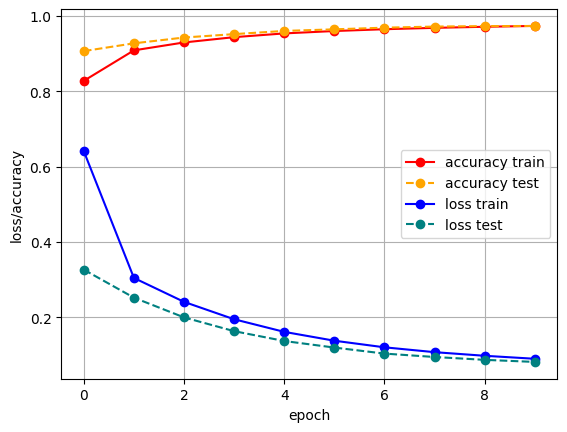

In [27]:
plt.figure(1);plt.clf()
plt.plot(df['epoch'],df['accuracy_train'],marker='o',color='red')
plt.plot(df['epoch'],df['accuracy_test'],marker='o',color='orange',linestyle='dashed')
plt.plot(df['epoch'],df['loss_train'],marker='o',color='blue')
plt.plot(df['epoch'],df['loss_test'],marker='o',color='teal',linestyle='dashed')
plt.grid()
plt.xlabel(r'epoch')
plt.ylabel(r'loss/accuracy')
plt.legend(['accuracy train','accuracy test','loss train','loss test'])
plt.show()

We can further analyze the performance of our network on the test set by computing its *confusion matrix*.

In [28]:
from sklearn.metrics import confusion_matrix
cm_test  = np.zeros((10,10), dtype=int)
# test all the images in the test set
with torch.no_grad():
    for X,y in myLoader_test:
        score = myModel(X)
        _, y_hat = torch.max(score.data, 1) # to estimate how many are correct
        cm_test += confusion_matrix(y,y_hat,labels=range(10))
# the result
cm_test

array([[ 973,    0,    1,    0,    0,    0,    1,    2,    3,    0],
       [   0, 1124,    4,    0,    0,    0,    2,    0,    5,    0],
       [   5,    7,  986,    7,    2,    0,    1,    9,   14,    1],
       [   0,    0,    2,  990,    0,    2,    0,    4,    7,    5],
       [   2,    0,    1,    0,  952,    0,    3,    4,    3,   17],
       [   2,    0,    1,   15,    0,  852,    7,    1,    9,    5],
       [   8,    1,    0,    0,    2,    4,  938,    0,    5,    0],
       [   0,    6,   11,    3,    0,    0,    0,  997,    1,   10],
       [   6,    0,    2,   11,    3,    1,    3,    2,  942,    4],
       [   5,    5,    1,    7,    5,    1,    1,    7,    2,  975]])

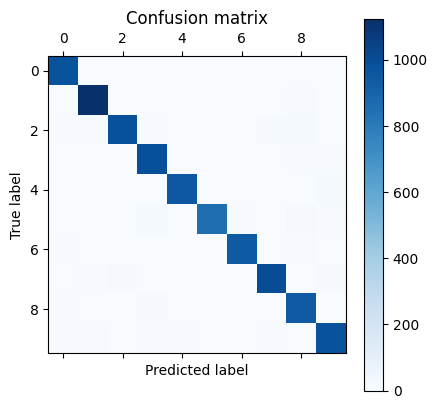

In [29]:
# plot
plt.matshow(cm_test,cmap="Blues")
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Predictions/inferences
## Loading an image

We can try our network on some other images. Let's import some basic drawing of a digit.

Downloading...
From: https://drive.google.com/uc?id=1ZvI7FJJ4xJZFnVNz4nfE5oLx-Tdf-Lk_
To: /content/digits_seb_6.png
100%|██████████| 2.00k/2.00k [00:00<00:00, 5.88MB/s]


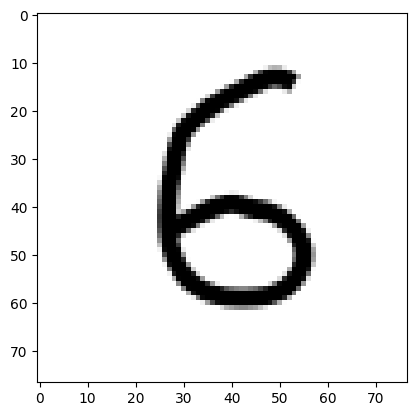

In [30]:
from PIL import Image
# pil_img = Image.open('digits_seb_6.png').convert('L')
import gdown
output = "digits_seb_6.png"
gdown.download("https://drive.google.com/uc?id=1ZvI7FJJ4xJZFnVNz4nfE5oLx-Tdf-Lk_", output, quiet=False)
pil_img = Image.open(output).convert('L')   # convert('L') to have a grey image
plt.imshow(pil_img,cmap="gray")

To apply our model on the image, we need several transformations:

- the image should be a tensor
- its size has to be 28x28



In [31]:
tensor_binary = transforms.ToTensor()(pil_img).unsqueeze_(0)    # -> tensor of size 1x1x..x..
x = torch.nn.functional.interpolate(tensor_binary, size=(28, 28), mode='bilinear')   # size 1x1x28x28
print(x.shape)

torch.Size([1, 1, 28, 28])


## Result
We now run our inference and compute the score of each class for this image

In [32]:
s = myModel(x)
p = torch.nn.functional.softmax(s.data,dim=1)
print("p = ", p)
print("predicted label = ", torch.argmax(p), " with probability ", torch.max(p))

p =  tensor([[9.0702e-05, 1.2346e-11, 1.4245e-09, 5.2682e-06, 7.3709e-05, 2.0283e-09,
         6.7523e-08, 1.2754e-09, 9.9980e-01, 3.0251e-05]])
predicted label =  tensor(8)  with probability  tensor(0.9998)


Completely wrong! The problem is that in our dataset the digit is written in white and the background is black. In the image loaded, it is the reverse. Therefore, we have to switch the two colors.

In [33]:
s = myModel(1-x)   # 0 becomes 1 and 1 becomes 0
p = torch.nn.functional.softmax(s.data,dim=1)
print("p = ", p)
print("predicted label = ", torch.argmax(p), " with probability ", torch.max(p))

p =  tensor([[2.8688e-05, 1.2838e-07, 6.4885e-04, 1.5928e-04, 1.0808e-07, 6.6758e-02,
         9.2736e-01, 7.2935e-07, 4.8928e-03, 1.5525e-04]])
predicted label =  tensor(6)  with probability  tensor(0.9274)


# Exercises

**Ex1.** Visualize the kernels of the first convolutional layer.

**Ex2.** Build a neural network with *at most* 500 parameters that performs with (at least) 95% accuracy.